In [34]:
import pandas as pd
import spacy
from spacy import displacy
import re
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

NER = spacy.load("en_core_web_sm")

# Step 1. Extract hard-skills

First, load the dataframe, and prepare it a little bit (We do not lowercase or delete punctuation signs because it can interfere with the model I am to use later)

In [8]:
def prepare_df(df, cols_to_keep=['title', 'company', 'description', 'position']):
    new_df=df[cols_to_keep]
    return new_df

In [9]:
df=prepare_df(pd.read_csv('jobs.csv'))

## NER MODEL

For extracting hard skills we use NER model from spacy. 
This model recognizes named entities such as companies, people, dates and so on.

The model identifies some skills but also identifies a lot of things which are not skills. Thus, we shall apply the model along with a couple of restrictions:
- Stop words. I've identified some words which do not appear in the name of the skills but are identified as ORG by NER. So I do not include entitites containing these words.
- Uppercasing. Technical skills are the names of the programs (like Python, Java, etc) so we only keep entities which begin with the uppercase.
- We also exclude the company name from the description, because this is not a skill.

**Such moves will reduce the amount of skills extracted and we may potentially miss a lot of skills. However, this is a tolerable limitation for the 1st step, because for now, we just need to have at least some skills.**

In [10]:
stops=['group', 'ontario', 'canada', 'rights', 'salary', 'company', 'operation', 'inc.', 'co-op', 'internship', 'startup', 'job', 'career']

In [11]:
def hard_skills(descr, compName):
    name=compName.lower()
    info=NER(descr)
    raw_skills=[]
    for ent in info.ents:
        if ent.text[0].isupper():
            extracted=ent.text.lower()
            if (ent.label_=='ORG' or ent.label=='PERSON') and extracted not in name and name not in extracted and not any(stop in extracted for stop in stops):
                raw_skills.append(extracted)
    ready_skills=[]
    for skill in raw_skills:
        splitted=re.split('[&,|/]', skill)
        for true_skill in splitted:
            if true_skill not in ready_skills:
                ready_skills.append(true_skill)
    return ready_skills

In [12]:
def add_hard_skills(df):
    hs=[]
    for row in df.itertuples(index=False):
        hs.append(hard_skills(row.description, row.company))
    new_df=df
    new_df['hard_skills']=hs
    return new_df

In [13]:
df_hard=add_hard_skills(df)
df_hard.head(5)

,title,company,description,position,hard_skills
0,"Capital Markets QTS - Developer, Summer PEY 20...",RBC,What is the opportunity?\nAs a Developer withi...,developer,"[qts, capital markets, quantitative technology..."
1,Software Developer (Entry-Level),Traction,About Traction Design Group\n\nTraction Design...,developer,"[tdg, http, dom, ssl]"
2,"newJunior Image Processing Software Developer,...",Sunnybrook Health Sciences Centre,"Junior Image Processing Software Developer, Su...",developer,"[sunnybrook research institute, campbell cogni..."
3,"Software Developer Intern, Bachelors, Summer 2022",Google,Please complete your application before Decemb...,developer,"[bachelor, computer science, software developm..."
4,newJob Developer – Employment Ontario (Nov 202...,WoodGreen Community Services,Employment Type: Full-Time – CUPE Bargaining U...,developer,"[cupe bargaining, eo, agency policies, contrac..."


## Skill's visualization

In [14]:
skills_arr=np.array(df['hard_skills'])
skills_arr

array([list(['qts', 'capital markets', 'quantitative technology', 'devops', 'data structures', 'javascript', 'react', 'angular', ' python', 'new grad', 'capital markets quantitative and technology services', 'talent community']),
       list(['tdg', 'http', 'dom', 'ssl']),
       list(['sunnybrook research institute', 'campbell cognitive neurology research unit', 'ondri', 'canadian consortium on neurodegeneration in aging', 'canadian alliance', 'cahhm', 'toronto dementia research alliance', 'tdra', 'brain-eye amyloid memory study', 'beam', 'medical imaging trials network', 'mitnec', 'pytorch', 'tensorflow', 'fsl', 'canadian employment and immigration', 'lgbtq2', 'university of toronto', 'goubran', 'medical biophysics', 'hospital']),
       list(['bachelor', 'computer science', 'software development', 'javascript', 'unix', 'linux', 'chrome', 'android', 'social to local']),
       list(['cupe bargaining', 'eo', 'agency policies', 'contractual guidelines', ' industry', 'microsoft applicat

In [15]:
def flat_2d_arr(arr):
    flat=[]
    for small in arr:
        for element in small:
            flat.append(element)
    return flat

In [16]:
skills_arr=flat_2d_arr(skills_arr)

#### The word cloud shows the most frequent words in the array of skills. We've been editing 'stops' until we've became satisfied with the results.

In [17]:
cnt = Counter() # Method for calculating occurences is taken from: https://stackoverflow.com/questions/4088265/sorted-word-frequency-count-using-python
for skill in skills_arr:
    cnt[skill] += 1
cnt

Counter({'qts': 5,
         'capital markets': 5,
         'quantitative technology': 5,
         'devops': 6,
         'data structures': 5,
         'javascript': 14,
         'react': 5,
         'angular': 5,
         ' python': 5,
         'new grad': 5,
         'capital markets quantitative and technology services': 5,
         'talent community': 5,
         'tdg': 5,
         'http': 5,
         'dom': 5,
         'ssl': 5,
         'sunnybrook research institute': 5,
         'campbell cognitive neurology research unit': 5,
         'ondri': 5,
         'canadian consortium on neurodegeneration in aging': 5,
         'canadian alliance': 5,
         'cahhm': 5,
         'toronto dementia research alliance': 5,
         'tdra': 5,
         'brain-eye amyloid memory study': 5,
         'beam': 5,
         'medical imaging trials network': 5,
         'mitnec': 5,
         'pytorch': 5,
         'tensorflow': 5,
         'fsl': 5,
         'canadian employment and immigration': 

In [18]:
sorted_freq_skills=cnt.most_common()
sorted_freq_skills

[('javascript', 14),
 ('gta', 12),
 ('ssis', 10),
 ('sql', 10),
 ('bachelor', 9),
 ('ssrs', 9),
 ('hospital', 8),
 ('microsoft office', 8),
 ('microsoft', 7),
 ('business intelligence', 7),
 ('dental', 7),
 ('devops', 6),
 ('bi developer', 6),
 ('etl', 6),
 ('ssas', 6),
 ('microsoft bi', 6),
 ('php', 6),
 ('qts', 5),
 ('capital markets', 5),
 ('quantitative technology', 5),
 ('data structures', 5),
 ('react', 5),
 ('angular', 5),
 (' python', 5),
 ('new grad', 5),
 ('capital markets quantitative and technology services', 5),
 ('talent community', 5),
 ('tdg', 5),
 ('http', 5),
 ('dom', 5),
 ('ssl', 5),
 ('sunnybrook research institute', 5),
 ('campbell cognitive neurology research unit', 5),
 ('ondri', 5),
 ('canadian consortium on neurodegeneration in aging', 5),
 ('canadian alliance', 5),
 ('cahhm', 5),
 ('toronto dementia research alliance', 5),
 ('tdra', 5),
 ('brain-eye amyloid memory study', 5),
 ('beam', 5),
 ('medical imaging trials network', 5),
 ('mitnec', 5),
 ('pytorch', 5)

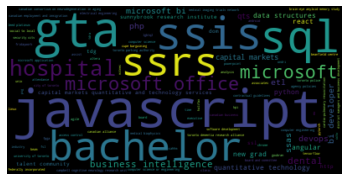

In [19]:
wordcloud = WordCloud().generate_from_frequencies(cnt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now, let's turn our skills into a set to delete repetitions.

In [20]:
set_skills=set(skills_arr)
set_skills

{'',
 ' abilities',
 ' allocation analysts',
 ' attendance',
 ' data governance',
 ' designer',
 ' experienceexperience',
 ' eyewear boutique',
 ' finance',
 ' industry',
 ' insurance',
 ' investments',
 ' light rail transit',
 ' management and central function',
 ' optimization for project delivery teams',
 ' outgoing',
 ' python',
 ' rock ‘n’',
 ' safety',
 ' team foundation version control',
 ' thriftys',
 ' time management',
 ' university',
 'access control',
 'agency policies',
 'aggressive ',
 'agile',
 'agm',
 'altera',
 'always',
 'aml',
 'analysis',
 'android',
 'angular',
 'asp.net mvc',
 'assist',
 'associates',
 'bachelor',
 'bachelor of computer science',
 'beam',
 'beanfield centre',
 'better world',
 'bi',
 'bi developer',
 'blackrock',
 'bluenotes',
 'board',
 'board and committee',
 'brain-eye amyloid memory study',
 'brookfield annuity',
 'brooks brothers',
 'building owners',
 'business equipment',
 'business intelligence',
 'buyers',
 'cahhm',
 'campbell cognitive n

Now, let's delete empty entries and trailing whitespaces from the set

In [21]:
better_skills={x.strip() for x in set_skills if (x!='' and (len(x)>1 or x=='r'))}
better_skills

{'abilities',
 'access control',
 'agency policies',
 'aggressive',
 'agile',
 'agm',
 'allocation analysts',
 'altera',
 'always',
 'aml',
 'analysis',
 'android',
 'angular',
 'asp.net mvc',
 'assist',
 'associates',
 'attendance',
 'bachelor',
 'bachelor of computer science',
 'beam',
 'beanfield centre',
 'better world',
 'bi',
 'bi developer',
 'blackrock',
 'bluenotes',
 'board',
 'board and committee',
 'brain-eye amyloid memory study',
 'brookfield annuity',
 'brooks brothers',
 'building owners',
 'business equipment',
 'business intelligence',
 'buyers',
 'cahhm',
 'campbell cognitive neurology research unit',
 'canadian alliance',
 'canadian business',
 'canadian consortium on neurodegeneration in aging',
 'canadian employment and immigration',
 'canadian investment review',
 'capital markets',
 'capital markets quantitative and technology services',
 'cardio-pulmonary resuscitation',
 'casino gaming industry',
 'cctv',
 'change management',
 'chrome',
 'city of toronto',
 '

Now, perform the same preprocessing for skills in out df

In [27]:
def basic_prepr_skills(df, col_skills):
    result=[]
    skills_2d=np.array(df[col_skills])
    for ent in skills_2d:
        prepr=[x.strip() for x in ent if (x!='' and (len(x)>1 or x=='r'))]
        result.append(prepr)
    new_df=df
    new_df[col_skills]=result
    return new_df

In [29]:
df_hard_prepr=basic_prepr_skills(df, 'hard_skills')

# STEP 2: Analyze the grammar structure

Now, let's analyze the role our identified skills play in the sentences. We do this by using Spacy linguistic tools. 
We want to know:
    - which part of speech each skill is (for skills made of a couple of words, treat each word as a skill, just for the purposes of this step)
    - how the word is related to the other words in the sentence

What we want to know:
- Are there any POS tags which are present in skills more frequently than in other words?
- Are there any roles which are present in skills more grequently than in words?
- Same questions for skills heads
**Note: head here means the word the skill is dependent on*
- What are the words contained in the skills heads?

In [30]:
simple_pos_all=[]
role_all=[]
simple_pos_skills=[]
role_skills=[]
head_skill_simple_pos=[]
head_skill_role=[]
head_text=[]
head_head_text=[]
all_descs=list(df['description'])
for desc in all_descs:
    nlp_desc=NER(desc.lower()) #Can lowercase everything now, because it won't affect the model
    for token in nlp_desc:
        simple=token.pos_
        role=token.dep_
        head_simple=token.head.pos_
        head_role=token.head.dep_
        ht=token.head.text
        hht=token.head.head.text
        if token.is_stop==False and token.pos_ not in['PUNCT', 'SPACE', 'AUX']:
            simple_pos_all.append(simple)
            role_all.append(role)
            if any(token.text in skill for skill in better_skills):
                simple_pos_skills.append(simple)
                role_skills.append(role)
                if token.head.is_stop==False and token.head.pos_ not in ['PUNCT', 'SPACE', 'AUX']:
                    head_skill_simple_pos.append(head_simple)
                    head_skill_role.append(head_role)
                    head_text.append(ht)
                if token.head.head.is_stop==False and token.head.head.pos_ not in ['PUNCT', 'SPACE', 'AUX']:
                    head_head_text.append(hht)
        

In [32]:
def calc_occ(arr):
    cnt=Counter()
    for word in arr:
        cnt[word]+=1
    return cnt

In [79]:
def gen_wordCloud(arr):
    wordcloud = WordCloud().generate_from_frequencies(calc_occ(arr))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

In [74]:
def gen_stack(arrs, colnames, gen='freq', ret=False, my_title=''):
    cnts=[]
    for arr in arrs:
        cnts.append(calc_occ(arr))
    dfs=[]
    for i in range (0, len(cnts)):
        df=pd.DataFrame(cnts[i].most_common(), columns=['LABEL', colnames[i]]).set_index('LABEL')
        dfs.append(df)
    final_df=dfs[0]
    for d in range (1, len(dfs)):
        final_df=pd.merge(final_df, dfs[d], on='LABEL')
    sums=[]
    for c in range (0, len(colnames)):
        summing=final_df[colnames[c]].sum()
        sums.append(summing)
    new_df=final_df
    freq_names=[]
    for f in range (0, len(sums)):
        name=colnames[f]+'_freq'
        freq_names.append(name)
        new_df[name]=new_df[colnames[f]]/sums[f]
    if gen=='freq':
        new_df[freq_names].plot(kind='bar', stacked=True, title=my_title)
    elif gen=='num':
        new_df[colnames].plot(kind='bar', stacked=True, title=my_title)
    if ret:
        return new_df

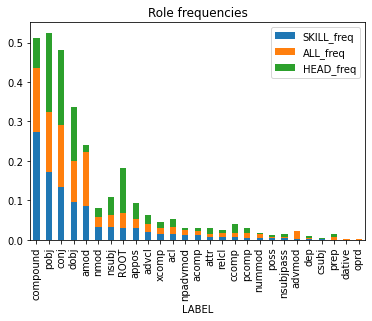

In [75]:
gen_stack([role_skills, role_all, head_skill_role], ['SKILL', 'ALL', 'HEAD'], my_title='Role frequencies')

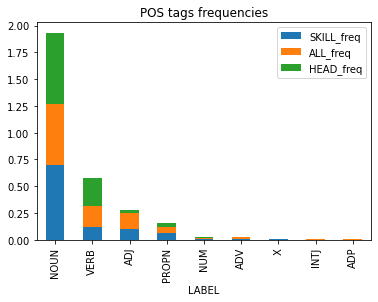

In [76]:
gen_stack([simple_pos_skills, simple_pos_all, head_skill_simple_pos], ['SKILL', 'ALL', 'HEAD'], my_title='POS tags frequencies')

As we can see, it is hard to identify any meaningful patterns here. We cannot find any roles or POS tags which appear disproprotionally in skills or skills heads. Let's move on to investigating the head words

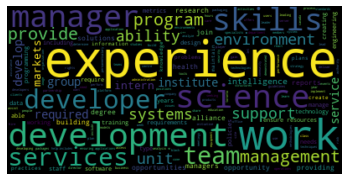

In [80]:
gen_wordCloud(head_text)

As we can see the words in the heads make sense, and they appear to be good predictors for future skills. Let's go one level down.

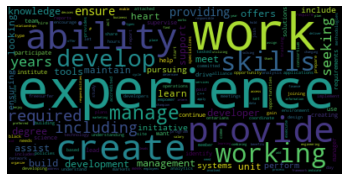

In [81]:
gen_wordCloud(head_head_text)

These words may also be important predictors.

## Conclusions for Step 2: 
**The roles in the sentences and POS (part-of-speech) tags are not good predictors of skills appearance. However, certain words in the heads are good predictors. Thus, in the next steps we will explore the relationship further: we will explore the families of each skill and see whether any patterns can be fiund there.**